In [1]:
%load_ext watermark
%watermark

2019-05-29T12:22:34+02:00

CPython 3.6.8
IPython 6.2.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.13.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


## 1. <a id='carga-del-dataframe'>Carga del DataFrame</a>

In [2]:
import math
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import calendar
import matplotlib.pyplot as plt
from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse
import warnings

%matplotlib inline
plt.rcParams['figure.figsize'] = (18,10)
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [3]:
df_U_FR = pd.read_pickle('../Data/02.-Creacion-del-DataFrame-df_U_FR.pkl')

df_U_FR.head()

,ds,y
0,2017-05-01,48
1,2017-05-02,2371
2,2017-05-03,2640
3,2017-05-04,2565
4,2017-05-05,1717


Representamos gráficamente la evolución de los envíos de U en Francia.

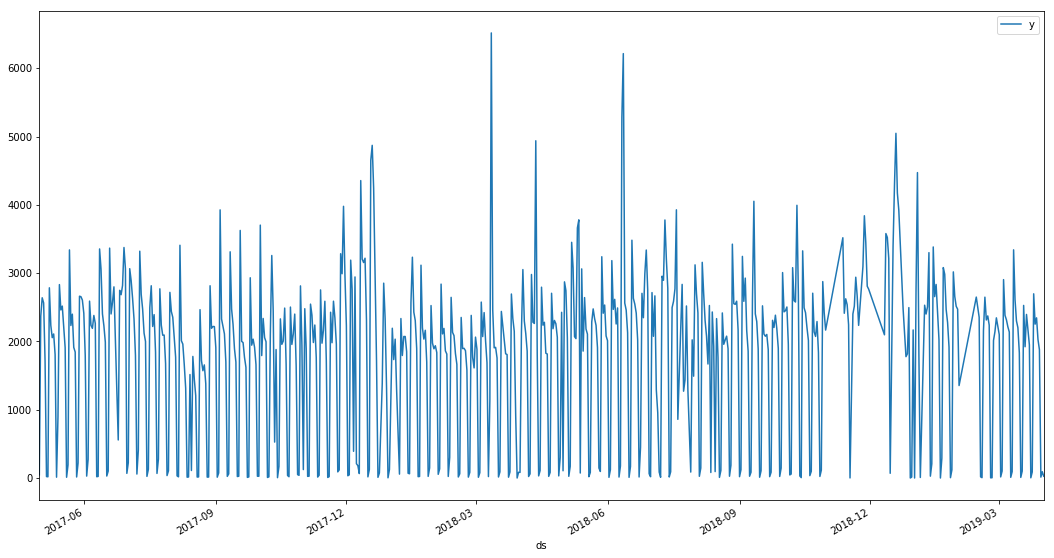

In [4]:
df_U_FR.plot.line(x = 'ds',y = 'y',figsize = (18,10));

## Fechas que faltan

Los días que faltan en df_U_FR es:

In [5]:
missing_dates = pd.date_range(start = '2017-05-01',end = '2019-04-01').difference(df_U_FR['ds'])

missing_dates

DatetimeIndex(['2017-06-24', '2017-12-25', '2018-01-01', '2018-01-06',
               '2018-07-21', '2018-07-22', '2018-07-28', '2018-11-01',
               '2018-11-02', '2018-11-03', '2018-11-04', '2018-11-05',
               '2018-11-06', '2018-11-07', '2018-11-08', '2018-11-09',
               '2018-11-10', '2018-11-11', '2018-11-18', '2018-11-24',
               '2018-11-25', '2018-12-01', '2018-12-02', '2018-12-03',
               '2018-12-04', '2018-12-05', '2018-12-06', '2018-12-07',
               '2018-12-08', '2018-12-09', '2018-12-10', '2018-12-16',
               '2018-12-22', '2018-12-23', '2018-12-25', '2019-01-06',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12'],
              dtype='datetime64[ns]', freq=None)

In [6]:
type(missing_dates)

pandas.core.indexes.datetimes.DatetimeIndex

In [7]:
len(missing_dates)

47

In [8]:
df_missing_dates = pd.DataFrame()

df_missing_dates['ds'] = missing_dates

df_missing_dates.head()

,ds
0,2017-06-24
1,2017-12-25
2,2018-01-01
3,2018-01-06
4,2018-07-21


In [9]:
len(df_missing_dates)

47

### Función que genera el número de envíos para una fecha que falta

In [10]:
def new_y_for_date(date,df_temp):
    df_monthdays_for_date = df_temp.loc[(df_temp['ds'].dt.year == date.year) &
                                        (df_temp['ds'].dt.month == date.month) &
                                        (df_temp['ds'].dt.weekday == date.weekday())]
    new_y = df_monthdays_for_date['y'].mean()
    if math.isnan(new_y) == False:
        return np.int(round(new_y))
    else:
        return np.int64(round(df_temp.loc[df_temp['ds'].dt.weekday == date.weekday()]['y'].mean()))

In [11]:
new_y_for_date(datetime.strptime('2017-06-24','%Y-%m-%d'),df_U_FR)

26

### Genera el número de envíos para un dataframe que contenga fechas que faltan

In [12]:
df_missing_dates['y'] = [new_y_for_date(date,df_U_FR) for date in df_missing_dates['ds']]

df_missing_dates.head()

,ds,y
0,2017-06-24,26
1,2017-12-25,4066
2,2018-01-01,2637
3,2018-01-06,39
4,2018-07-21,52


In [13]:
df_missing_dates.tail()

,ds,y
42,2019-02-08,1983
43,2019-02-09,11
44,2019-02-10,6
45,2019-02-11,2086
46,2019-02-12,2396


### Generamos el dataframe df_U_FR final con todas las fechas y ordenado

In [14]:
df_U_FR = df_U_FR.append(df_missing_dates)

In [15]:
df_U_FR['ds'] = pd.to_datetime(df_U_FR['ds'])

In [16]:
df_U_FR = df_U_FR.sort_values(by = 'ds')

df_U_FR = df_U_FR.reset_index(drop = True)

Comprobamos que todo está correcto:

In [17]:
pd.date_range(start = '2017-05-01',end = '2019-04-01').difference(df_U_FR['ds'])

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [18]:
df_U_FR.head()

,ds,y
0,2017-05-01,48
1,2017-05-02,2371
2,2017-05-03,2640
3,2017-05-04,2565
4,2017-05-05,1717


In [19]:
df_U_FR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 2 columns):
ds    701 non-null datetime64[ns]
y     701 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.0 KB


## Prophet 

In [20]:
len(df_U_FR)

701

Vamos a hacer la predicción para Febrero y Marzo del 2019

In [21]:
df_train = df_U_FR.iloc[:641]

df_test = df_U_FR.iloc[641:]

In [22]:
df_test.head()

,ds,y
641,2019-02-01,1355
642,2019-02-02,11
643,2019-02-03,6
644,2019-02-04,2086
645,2019-02-05,2396


In [23]:
f = Prophet()

f.add_country_holidays(country_name = 'FRA')

f.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
df_temp = f.make_future_dataframe(periods = 60)

In [25]:
df_temp.head()

,ds
0,2017-05-01
1,2017-05-02
2,2017-05-03
3,2017-05-04
4,2017-05-05


In [26]:
df_temp.tail()

,ds
696,2019-03-28
697,2019-03-29
698,2019-03-30
699,2019-03-31
700,2019-04-01


In [31]:
df_forecast = f.predict(df_temp)

df_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Armistice 1918,Armistice 1918_lower,Armistice 1918_upper,Armistice 1945,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
696,2019-03-28,2038.805242,1932.449371,3430.719380,2036.638881,2041.275889,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,627.591572,627.591572,627.591572,0.0,0.0,0.0,2666.396814
697,2019-03-29,2039.620497,1462.975207,2938.218572,2037.388341,2042.170947,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,174.516835,174.516835,174.516835,0.0,0.0,0.0,2214.137332
698,2019-03-30,2040.435752,-357.035405,1126.861751,2038.108434,2043.044293,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1678.805822,-1678.805822,-1678.805822,0.0,0.0,0.0,361.629930
699,2019-03-31,2041.251007,-320.619697,1120.827677,2038.898451,2043.917884,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1646.791723,-1646.791723,-1646.791723,0.0,0.0,0.0,394.459284
700,2019-04-01,2042.066262,2512.325570,3967.022393,2039.645013,2044.793050,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1175.263792,1175.263792,1175.263792,0.0,0.0,0.0,3217.330055


## PLOTS CON ERRORES (???)

TypeError: float() argument must be a string or a number, not 'Period'

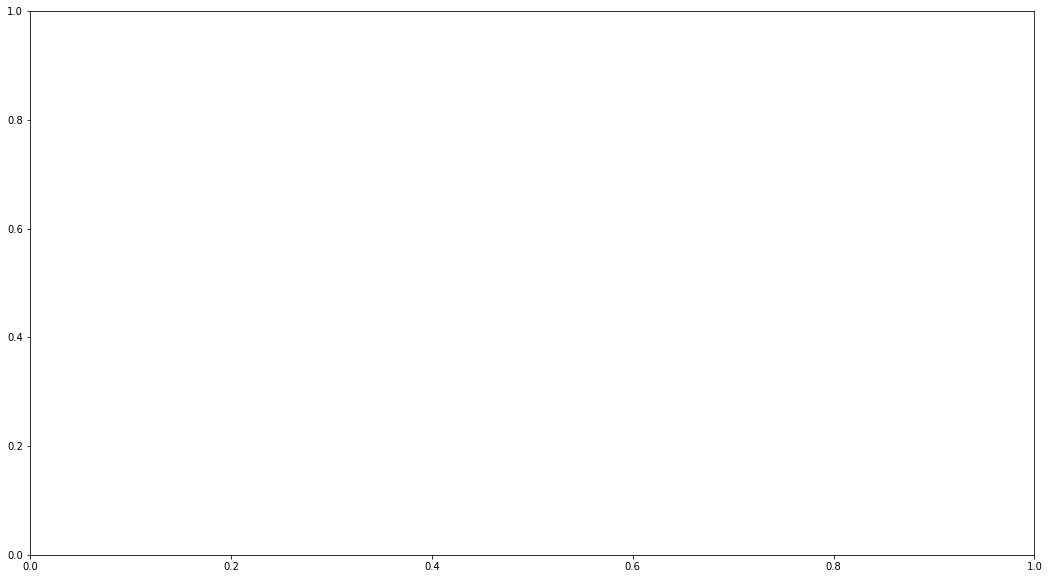

In [32]:
ax = df_forecast.plot(x = 'ds',y = 'yhat',label = 'forecast',legend = True,figsize = (18,10));

df_test.plot(x = 'ds',y = 'y',
             label = 'test',
             legend =True,
             ax = ax,
             xlim = (pd.Timestamp('2019-02-01'),pd.Timestamp('2019-04-01')));

TypeError: float() argument must be a string or a number, not 'Period'

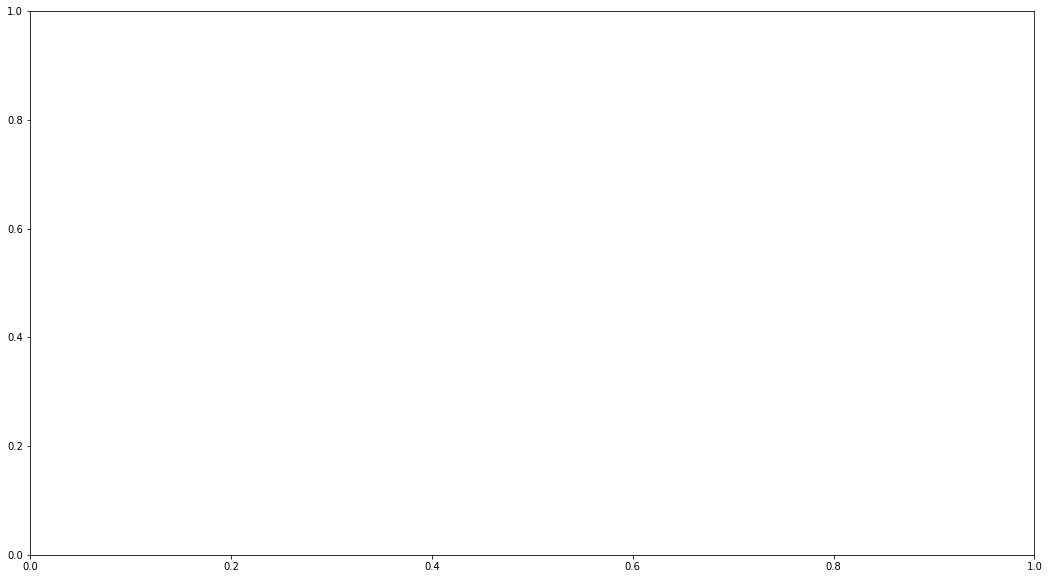

In [29]:
df_test.plot(x = 'ds',y = 'y',figsize = (18,10));

## OTROS PLOTS

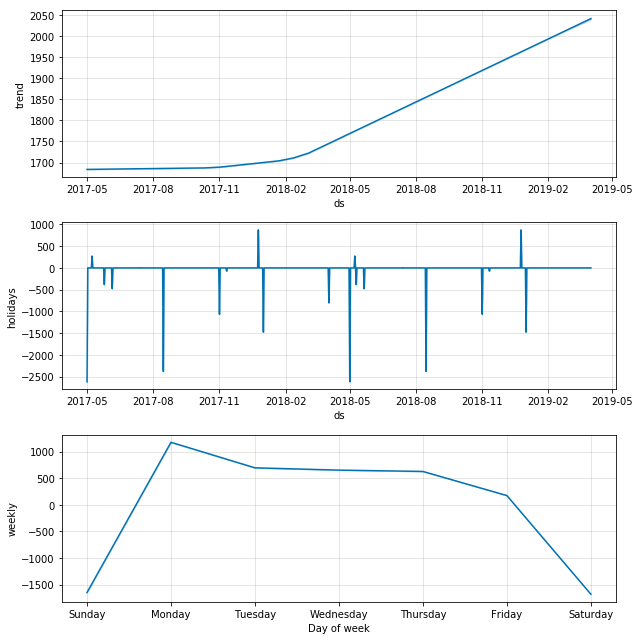

In [33]:
f.plot_components(df_forecast);

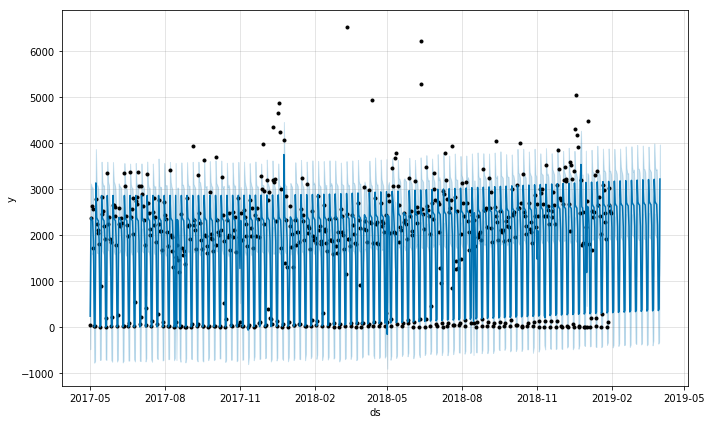

In [34]:
f.plot(df_forecast);

## RMSE 

In [35]:
predictions = df_forecast.iloc[-60:]['yhat']

predictions.head()

641    2168.483055
642     315.975652
643     348.805007
644    3171.675777
645    2692.786722
Name: yhat, dtype: float64

In [36]:
rmse(predictions,df_test['y'])

610.2464236730962